### MEC2015 - System Identification

#### Student: Felipe da Costa Pereira



___

#### Activity Number 04 - Recusrsive Least squares

Activity 2: IFAC SYSID 2015 benchmark data

- Read the paper [2] and check the measured data in https:  
//www.kth.se/social/group/system-identificatio/page/17th-ifac-symposium-on-system-identifica/  
The datasets and paper have been uploaded in our shared folder, for your convenience  
- Choose one dataset with ramp scheduling signal and treat your system as linear time-varying (you don’t know the scheduling signal)  
- Generate the results for the RLS methods for time-varying processes  
- Describe your numerical experiments, summarize the results in a table, and choose one to report the graphs of predictions and model parameters vs. time   
- Tip: you can use the transfer function information described in Fig. 2 in [2] to define the model orders  


In [1]:
pkg load control;
clc
clear
close all
rng(1) % permite reproducibilidade

Inspecting $u$ and $y$

In [2]:
% filename = './data/MS_Ramp_N15640_RMS70_P2P350.mat';
filename = './data/MS_Ramp_N15640_RMS140_P2P350.mat';

whos('-file', filename)
load(filename);
size(u_m)


Variables in the file ./data/MS_Ramp_N15640_RMS140_P2P350.mat:


variables in scope: $dummy_scope$

  Attr   Name        Size                     Bytes  Class
  ====   ====        ====                     =====  ===== 
         fs          1x1                          8  double
         p_m     46920x3                    1126080  double
         p_ref   15640x3                     375360  double
         u_m     46920x3                    1126080  double
         u_ref   15640x3                     375360  double
         y_m     46920x3                    1126080  double

Total is 516121 elements using 4128968 bytes

ans =

   46920       3



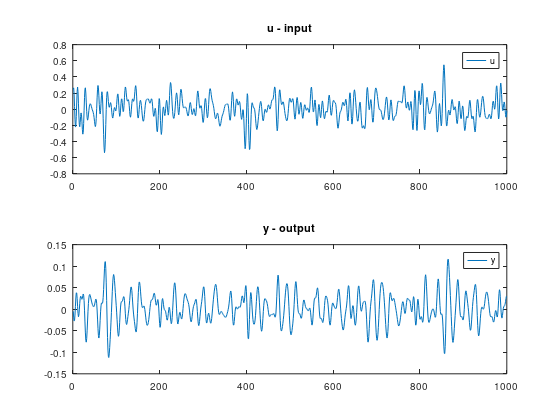

In [3]:
realization = 1; % 1, 2 or 3

u = u_m(:,realization);
y = y_m(:,realization);
ps = p_m(:,realization);

% u = u_m(1:15640,realization);
% y = y_m(1:15640,realization);

N=length(u);
t = (1:N)';
range = 1:1000;

subplot (211), plot(u(range)), title('u - input'), legend('u');
subplot (212), plot(y(range)), title('y - output'), legend('y');

Model order:  
As described in Fig.2 at the paper, the TF has two poles and one zero. Lets choose, then, $n_{a}=2$ and $n_{b}=1$

In [4]:
na=2;
nb=1;

Initialize parameters

In [5]:
P0  = 1*eye(na+nb);  % P initial condition

th = 0*ones(na+nb,1); % theta initial condition

trp1 = zeros(N,1);
trp2 = zeros(N,1);
trp3 = zeros(N,1);

lambda = 0.9992;     % forgetting factor

In [6]:
th1=th;

yh1 = zeros(N,1);  % prediction
e1  = zeros(N,1);  % prediction error
a1h1 = zeros(N,1);
a2h1 = zeros(N,1);
b1h1 = zeros(N,1);

th2=th;
yh2 = zeros(N,1);  % prediction
e2  = zeros(N,1);  % prediction error
a1h2 = zeros(N,1);
a2h2 = zeros(N,1);
b1h2 = zeros(N,1);

th3=th;
yh3 = zeros(N,1);  % prediction
e3  = zeros(N,1);  % prediction error
a1h3 = zeros(N,1);
a2h3 = zeros(N,1);
b1h3 = zeros(N,1);

P1=P0;
P2=P0;
P3=P0;


Choose wether or not to adjust q in order to the random walk procedure to achieve convergence.   

We've noticed that the random walk algorithm was not converging for the standard heuristic $q$, so a modification was done in the heuristic proposed in the classroom notes:

- Before:  

> $ Q(k) = q \times I_{p \times p}$  
> 
> where:    $q = \frac{Trace[(P(k)]}{n_{a}+n_{b}+1}$


- After:  

> $ Q_{modif}(k) = q_{modif} \times  I_{p \times p}$
> 
> where: $q_{modif} = \frac{Trace[(P(k)]}{(n_{a}+n_{b}+1) \times q_{corr}}$



In [7]:
% q_correction = 1; heuristic definition on the class notes
q_corr = 100;

RLS algorithm for strategies 1 (RLS), 2 (Random Walk) and 3 (Forgetting Factor)

In [8]:
for k=3:N
    % Step 2
    phi = [-y'(k-1:-1:k-na) u'(k-1:-1:k-nb)]';  % regression vector    

    % Step 3
    yh1(k) = phi'*th1;
    yh2(k) = phi'*th2;
    yh3(k) = phi'*th3;
    e1(k) = y(k) - yh1(k);
    e2(k) = y(k) - yh2(k);
    e3(k) = y(k) - yh3(k);
    
    % Step 4
    K1 = P1*phi/(1+phi'*P1*phi);
    K2 = P2*phi/(1+phi'*P2*phi);
    K3 = P3*phi/(lambda+phi'*P3*phi);
    
    % Step 5
    th1 = th1 + K1 * e1(k);
    th2 = th2 + K2 * e2(k);
    th3 = th3 + K3 * e3(k);
    
    % Step 6    

    % case 1 % RLS
    P1 = P1-K1*(P1*phi)'; 

    % case 2 % random walk
    P2 = P2-K2*(P2*phi)'; 
    p = length(th2)+1;
    q = trace(P2)/(p*q_corr);
    Q = q*eye(size(P2));
    P2 = P2 + Q;

    % case 3 % forgetting factor
    P3 = 1/lambda*(P3-K3*(P3*phi)');
        
    % store estimated parameters for plotting
    a1h1(k) = th1(1);
    a2h1(k) = th1(2);
    b1h1(k) = th1(3);
    
    a1h2(k) = th2(1);
    a2h2(k) = th2(2);
    b1h2(k) = th2(3);
    
    a1h3(k) = th3(1);
    a2h3(k) = th3(2);
    b1h3(k) = th3(3);

    % store trace of P for plotting
    trp1(k) = trace(P1);
    trp2(k) = trace(P2);
    trp3(k) = trace(P3);
end

In [9]:
fprintf('R2\n')
fprintf('Recursive Least Squares: \t\t %0.4f \n', mult_corr(y, yh1));
fprintf('RLS + Random Walk: \t\t\t %0.4f \n', mult_corr(y, yh2));
fprintf('Forgetting factor (lambda = %0.3f): \t %0.4f \n', lambda, mult_corr(y, yh3));

R2
Recursive Least Squares: 		 0.9270 
RLS + Random Walk: 			 0.9853 
Forgetting factor (lambda = 0.999): 	 0.9768 


> Summary of simulated parameters, and R2 results
> 
> $$
> \begin{aligned}
> % & \text {Table 1.1. A Jupyter notebook table using LaTeX }\\
> 
> &\begin{array}{cccc}
> \hline Case & q & P & R^2(RLS) & R^2(Random Walk) & R^2(ForgettingFactor) \\
> \hline 
> 001 & q_{corr}=1 \text{(class notes)}     & 100   & 0.9876 &  -     &  0.9883 \\
> 002 & q_{corr}=1 \text{(class notes)}     & 10    & 0.9666 &  -     &  0.9790 \\
> 003 & q_{corr}=1 \text{(class notes)}     & 1     & 0.8651 &  -     &  0.9494 \\
> 004 & q_{corr}=100 \text{(q modified)}   & 100   & 0.9876 &  0.9886  &  0.9883 \\
> 005 & q_{corr}=100 \text{(q modified)}   & 10    & 0.9666 &  0.9844  &  0.9790 \\
> 006 & q_{corr}=100 \text{(q modified)}   & 1     & 0.8651 &  0.9753  &  0.9494 \\
> \hline
> \end{array}
> \end{aligned}
> $$

> Comments on the results:  
> - With the heuristic proposed in the class notes, the random walk procedure did not succeed to converge (cases 001,002 and 003), so we have penalized the q factor by dividing it by another scale factor ($q_{corr}$) in order to the algorithm to achieve the convergence (cases 004, 005 and 006)
> - Several values have been testes for the $\lambda$, a reasonable value for that dataset was $\lambda=0.9992$, which has been used in all the described cases
> - Different values of the covariance matrix initialization $P(k)$ were tested. For higher values of $P(k)$ (case 004), it's more difficult to distinguish between the 3 methods as the simple RLS has already a good result in determining the parameters values. 
> - When we initialize the $P(k)$ matrix with lower values, it seems like the RLS doesn't capture the dinamics of the system parameters changing anymore. In these cases (005 and 006), it's clear that the strategies for updating $P(k)$ are usefull to detect the varuability in the system parameters change and the results between the 3 methods are quite different
> - The following plots will be made considering case 006 to show the difference in this dataset   


Plots of $y_{real}$, $y_{predicted}$ and $errors$

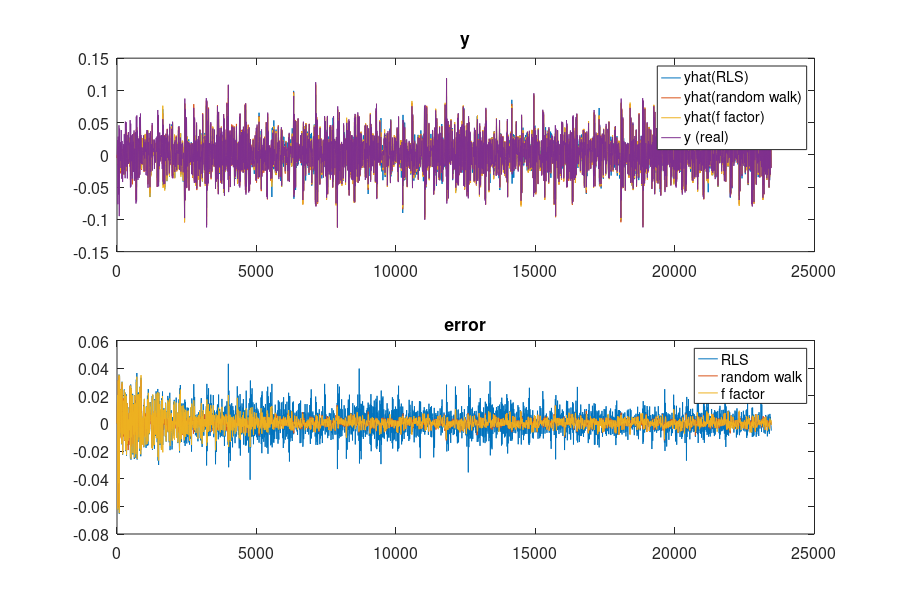

In [10]:
% plot output: real vs estimated and residual
lim_plot_range = 1:10:N/2;
% lim_plot_range = 1:1:2000;

figure
set(gcf, 'Position', [0 0 900 600]);
subplot(2,1,1)
plot(t(lim_plot_range),[yh1(lim_plot_range) yh2(lim_plot_range) yh3(lim_plot_range) y(lim_plot_range)])
title ('y')
legend('yhat(RLS)', 'yhat(random walk)', 'yhat(f factor)', 'y (real)')
subplot(2,1,2)
plot(t(lim_plot_range),[e1(lim_plot_range) e2(lim_plot_range) e3(lim_plot_range)])
title ('error')
legend('RLS', 'random walk', 'f factor')


Comments:  

- Error decreases over time when using the methods for updating $P(k)$

Parameters over time

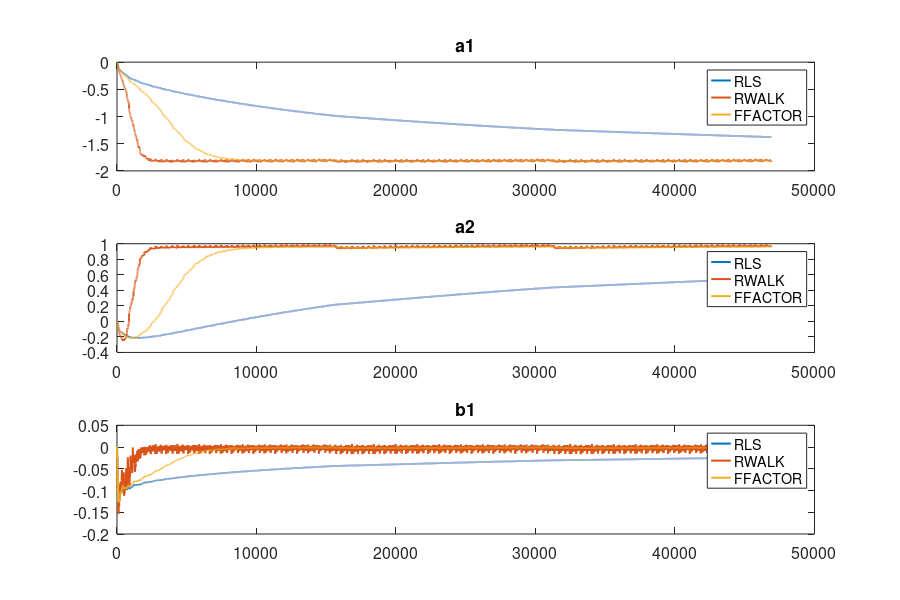

In [40]:
lim_plot_range = 1:N;

figure
set(gcf, 'Position', [0 0 900 600]);
subplot(311),plot(t(lim_plot_range),[a1h1(lim_plot_range) a1h2(lim_plot_range) a1h3(lim_plot_range)],'Linewidth',2), title('a1'), legend('RLS', 'RWALK', 'FFACTOR');
subplot(312),plot(t(lim_plot_range),[a2h1(lim_plot_range) a2h2(lim_plot_range) a2h3(lim_plot_range)],'Linewidth',2), title('a2'), legend('RLS', 'RWALK', 'FFACTOR');
subplot(313),plot(t(lim_plot_range),[b1h1(lim_plot_range) b1h2(lim_plot_range) b1h3(lim_plot_range)],'Linewidth',2), title('b1'), legend('RLS', 'RWALK', 'FFACTOR');

Comments:  

- For this magnitude of initialization of $P(k)$, the RLS method can't capture the system dynamics

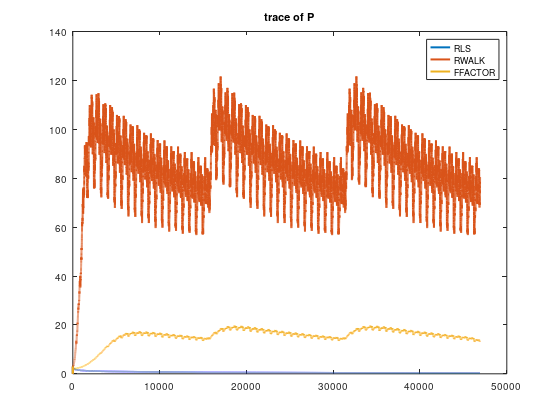

In [12]:
figure
plot(t, [trp1 trp2 trp3],'Linewidth',2), title('trace of P'), legend('RLS', 'RWALK', 'FFACTOR');

Comments:  

- Trace of $P(k)$ monotonically decreases only in the RLS case. Although in the other methods we can also see a decreasing tendency
- For the cases in which the random walk procedure did not converge, the behavior of the trace of $P(k)$ was much more chaotic, achieving higher values over time

Plotting the scheduling signal against the model params

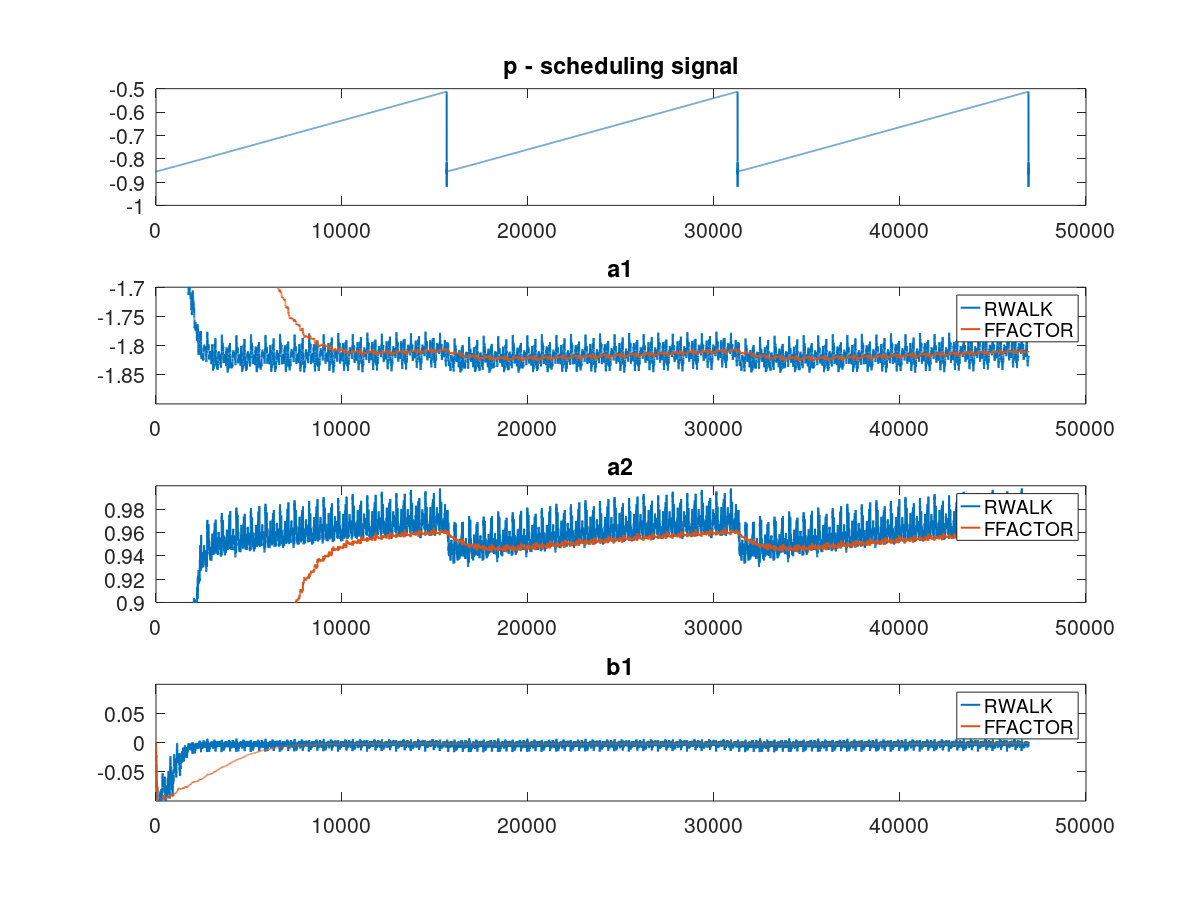

In [38]:
figure
set(gcf, 'Position', [0 0 1200 900]);

subplot (411), plot (t, ps ,'Linewidth',2), title('p - scheduling signal');
ylim([-1 -.5])
subplot (412), plot (t, [a1h2 a1h3],'Linewidth',2), title('a1'), legend('RWALK', 'FFACTOR');
ylim([-1.9 -1.7])
subplot (413), plot (t, [a2h2 a2h3],'Linewidth',2), title('a2'), legend('RWALK', 'FFACTOR');
ylim([.9 1])
subplot (414), plot (t, [b1h2 b1h3],'Linewidth',2), title('b1'), legend('RWALK', 'FFACTOR');
ylim([-.1 .1])

Notes:    
1. The estimated parameters $a_{1}$ and $a_{2}$ have correlation with the scheduling signal $p$ but no correlation is observed between $b_{1}$ and $p$.
2. As $b_{1}=0$, the system response has no dependency on the input and an order $n_{b}=0$ could have been chosen instead of $n_{b}=1$.